In [ ]:
!pip install -q condacolab
import condacolab
condacolab.install()
# Install all your required packages here using mamba
!mamba install -q scikit-learn graph-tool

⏬ Downloading https://github.com/jaimergp/miniforge/releases/download/24.11.2-1_colab/Miniforge3-colab-24.11.2-1_colab-Linux-x86_64.sh...
📦 Installing...
📌 Adjusting configuration...
🩹 Patching environment...
⏲ Done in 0:00:40
🔁 Restarting kernel...
Preparing transaction: ...working... done
Verifying transaction: ...working... done
Executing transaction: ...working... 


done


In [ ]:
from graph_tool.all import *

g = collection.data["celegansneural"]
state = minimize_nested_blockmodel_dl(g)

In [ ]:
# %env NX_CUGRAPH_AUTOCONFIG=True

# import networkx as nx
# print(f"using networkx version {nx.__version__}")

# nx.config.warnings_to_ignore.add("cache")

env: NX_CUGRAPH_AUTOCONFIG=True
using networkx version 3.4.2


In [ ]:
import torch
from torch.utils.data import Subset
import torchvision
from torchvision import transforms
import matplotlib.pyplot as plt


In [ ]:
# Define the transformation pipeline:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: (x > 0.5).float()),  # Binarize the image
    transforms.Lambda(lambda x: x.view(-1))           # Flatten into a 784-dim vector
])

# Load the training set (set download=True if running for the first time)
mnist_train = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform)


100%|██████████| 9.91M/9.91M [00:00<00:00, 37.1MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.09MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 8.89MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.63MB/s]


In [ ]:
# Get indices for images where the label is 1
indices = (mnist_train.targets == 1).nonzero().squeeze()

# Create a subset containing only the '1's
mnist_train_ones = Subset(mnist_train, indices)

print(f"Total number of '1' images in the training set: {len(mnist_train_ones)}")


Total number of '1' images in the training set: 6742


In [ ]:
# Stack all 784-dim vectors from the filtered dataset
all_vectors = torch.stack([img for img, _ in mnist_train_ones])
unique_vectors = torch.unique(all_vectors, dim=0)

print(f"Total images in mnist_train_ones: {all_vectors.shape[0]}")
print(f"Unique images: {unique_vectors.shape[0]}")

if all_vectors.shape[0] == unique_vectors.shape[0]:
    print("All 784-dimensional vectors are unique.")
else:
    print("There are duplicates in the 784-dimensional vectors.")


Total images in mnist_train_ones: 6742
Unique images: 6726
There are duplicates in the 784-dimensional vectors.


In [ ]:
# prompt: turn unique_vectors into numpy then save it on disk

import numpy as np

# Convert the unique vectors tensor to a NumPy array
unique_vectors_np = unique_vectors.numpy()

# Save the NumPy array to disk
np.save("unique_vectors.npy", unique_vectors_np)

print("Unique vectors saved to unique_vectors.npy")


Unique vectors saved to unique_vectors.npy


In [ ]:
# prompt: read unique_vectors.npy

import numpy as np

# Load the saved NumPy array
unique_vectors = np.load('unique_vectors.npy')

# Now you can work with the unique_vectors array
print(unique_vectors.shape)
unique_vectors


(6726, 784)


array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [ ]:
import numpy as np
from sklearn.neighbors import NearestNeighbors
import graph_tool as gt

def visualize_threshold_graph_gt(unique_vectors, distance_threshold):
    """
    Builds and visualizes a graph with graph-tool where each unique vector is a node and an edge is added
    between nodes if their Euclidean distance is <= distance_threshold.

    The visualization uses a force-directed layout (sfdp) from graph-tool.

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.

    Returns:
        g (graph_tool.Graph): The constructed graph.
    """
    # Convert tensor to numpy array if necessary.
    X = unique_vectors

    n = X.shape[0]
    print(f"Building graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold.
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='auto').fit(X)
    distances, indices = nbrs.radius_neighbors(X)

    # Create an undirected graph using graph-tool.
    g = gt.Graph(directed=False)
    g.add_vertex(n)  # Add n vertices

    edge_list = []
    for i, neigh in enumerate(indices):
        # For each neighbor j of node i (including itself),
        # add edge only if i < j to avoid duplicates.
        edge_list.extend([(i, j) for j in neigh if i < j])

    # Convert the list of edges to a NumPy array of type int32.
    edge_array = np.array(edge_list, dtype=np.int32)

    # Now add all edges at once.
    g.add_edge_list(edge_array)
    print(f"Graph built with {g.num_edges()} edges.")

    # Compute a force-directed layout using graph-tool's sfdp_layout.
    pos = gt.draw.sfdp_layout(g)

    # Draw the graph and save the visualization.
    gt.draw.graph_draw(g, pos=pos, output_size=(800, 800), vertex_size=5,
                  vertex_fill_color="blue", edge_pen_width=1.2,
                  output="graph_tool_graph.png")
    print("Graph visualization saved as 'graph_tool_graph.png'")

    return g

# Example usage:
g = visualize_threshold_graph_gt(unique_vectors, distance_threshold=6)


Building graph for 6726 nodes...
Graph built with 4681902 edges.
Graph visualization saved as 'graph_tool_graph.png'


In [ ]:
import numpy as np
import graph_tool.all as gt
import graph_tool.topology as gt_topo

def find_furthest_nodes_double_sweep_largest_component(g, X):
    """
    For a graph g (built with graph-tool) and an array X of shape (n, 784) corresponding to the
    unique vectors (with row i corresponding to vertex i), this function:
      1. Adds a vertex property to store original indices.
      2. Extracts the largest connected component.
      3. Finds two nodes that are farthest apart (approximate diameter endpoints) using a double-sweep algorithm
         on the subgraph.
      4. Computes the shortest path between them in the subgraph.
      5. Maps the subgraph vertices back to the original graph using the stored property.
      6. Extracts the corresponding 784-d vectors and computes delta vectors along the path.

    Returns:
      endpoints_sub: Tuple with the two endpoint indices in the subgraph (original indices).
      path_indices: List of original graph vertex indices along the shortest path.
      path_vectors: Array of the corresponding 784-d vectors for each vertex on the path.
      path_deltas: List of delta vectors between consecutive nodes on the path.
    """
    # --- Step 1: Store original vertex indices as a vertex property ---
    orig_index = g.new_vertex_property("int")
    for v in g.vertices():
        orig_index[v] = int(v)

    # --- Step 2: Extract the largest connected component ---
    comp, hist = gt.label_components(g)
    largest_comp = np.argmax(hist)
    vfilt = comp.a == largest_comp
    g_sub = gt.GraphView(g, vfilt=vfilt)

    # Build a mapping from subgraph vertex object to original graph index.
    vertex_to_orig = {v: int(orig_index[v]) for v in g_sub.vertices()}
    # Also, get a list of subgraph vertices.
    vertices_sub = list(g_sub.vertices())
    n_sub = len(vertices_sub)
    print(f"Largest connected component has {n_sub} vertices (out of {int(g.num_vertices())} total).")

    # --- Step 3: Double Sweep Algorithm on the subgraph ---
    # Use the list of vertices instead of range(n_sub)
    v0 = vertices_sub[0]
    dmap = gt.shortest_distance(g_sub, source=v0)
    # Find the vertex farthest from v0 among vertices_sub.
    farthest_idx = np.argmax([dmap[v] for v in vertices_sub])
    v1 = vertices_sub[farthest_idx]

    dmap2 = gt.shortest_distance(g_sub, source=v1)
    farthest_idx2 = np.argmax([dmap2[v] for v in vertices_sub])
    v2 = vertices_sub[farthest_idx2]

    endpoints_sub = (vertex_to_orig[v1], vertex_to_orig[v2])
    diameter_length = dmap2[v2]
    print("Diameter endpoints in subgraph (original indices):", endpoints_sub, "with length:", diameter_length)

    # --- Step 4: Compute the shortest path in the subgraph between v1 and v2 ---
    path_vertices_sub, _ = gt_topo.shortest_path(g_sub, source=v1, target=v2)
    # path_vertices_sub is a list of vertex objects in g_sub.
    print("Shortest path in subgraph (vertex objects):", list(path_vertices_sub))

    # --- Step 5: Map subgraph vertex objects back to original graph indices ---
    path_indices = [vertex_to_orig[v] for v in path_vertices_sub]
    print("Mapped original graph vertex indices for path:", path_indices)

    # --- Step 6: Extract the corresponding 784-d vectors and compute delta vectors ---
    path_vectors = X[path_indices]
    path_deltas = [path_vectors[i+1] - path_vectors[i] for i in range(len(path_vectors) - 1)]

    return endpoints_sub, path_indices, path_vectors, path_deltas

# Example usage:
# Assume unique_vectors is your NumPy array of shape (n, 784)
endpoints_sub, path_indices, path_vectors, path_deltas = find_furthest_nodes_double_sweep_largest_component(g, unique_vectors)

print("\n--- Results ---")
print("Furthest endpoints in subgraph (original indices):", endpoints_sub)
print("Path indices (original graph):", path_indices)
print("Path vectors shape:", np.array(path_vectors).shape)
print("Number of delta vectors:", len(path_deltas))


Largest connected component has 6631 vertices (out of 6726 total).
Diameter endpoints in subgraph (original indices): (6552, 0) with length: 10
Shortest path in subgraph (vertex objects): [<Vertex object with index '6552' at 0x7a3df1550fc0>, <Vertex object with index '2345' at 0x7a3df1550b40>, <Vertex object with index '6425' at 0x7a3df1550ec0>, <Vertex object with index '6439' at 0x7a3df1550e40>, <Vertex object with index '6168' at 0x7a3df1550dc0>, <Vertex object with index '1227' at 0x7a3df1550d40>, <Vertex object with index '4' at 0x7a3df1550cc0>, <Vertex object with index '127' at 0x7a3df1550c40>, <Vertex object with index '2506' at 0x7a3df1550bc0>, <Vertex object with index '1' at 0x7a3df1550ac0>, <Vertex object with index '0' at 0x7a3df4a733c0>]
Mapped original graph vertex indices for path: [6552, 2345, 6425, 6439, 6168, 1227, 4, 127, 2506, 1, 0]

--- Results ---
Furthest endpoints in subgraph (original indices): (6552, 0)
Path indices (original graph): [6552, 2345, 6425, 6439, 

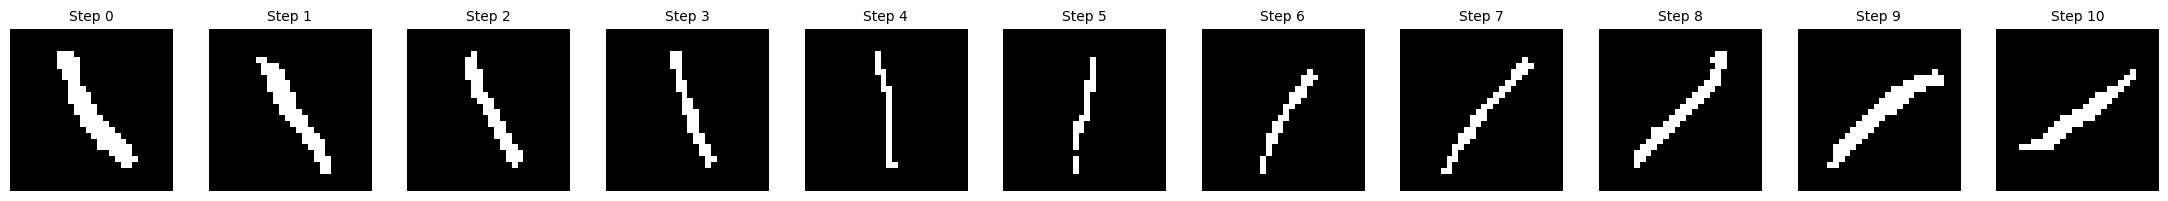

In [ ]:
import matplotlib.pyplot as plt

def plot_path_as_images(path_vectors):
    """
    Given an array of 784-d vectors (each representing an MNIST image),
    reshapes them into 28x28 images and plots them side-by-side.

    Args:
        path_vectors (np.array): Array of shape (n_steps, 784)
    """
    num_steps = len(path_vectors)
    # Create a figure with one subplot per image along the path.
    fig, axs = plt.subplots(1, num_steps, figsize=(num_steps * 2, 2))

    # If only one image, ensure axs is iterable.
    if num_steps == 1:
        axs = [axs]

    for i, vec in enumerate(path_vectors):
        img = vec.reshape(28, 28)
        axs[i].imshow(img, cmap='gray')
        axs[i].axis("off")
        axs[i].set_title(f"Step {i}", fontsize=10)

    plt.tight_layout()
    plt.show()

# Assuming path_vectors is the output from the previous function
plot_path_as_images(path_vectors)


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.manifold import TSNE
import networkx as nx

def visualize_threshold_graph(unique_vectors, distance_threshold):
    """
    Builds and visualizes a graph where each unique vector is a node and an edge is added
    between nodes if their Euclidean distance is <= distance_threshold.

    The visualization uses t-SNE to embed the nodes into 2D (to mimic a Kepler Mapper style).

    Args:
        unique_vectors (torch.Tensor or np.array): Array/tensor of shape (n, 784) containing unique images.
        distance_threshold (float): Maximum Euclidean distance for adding an edge between two nodes.
    """
    # Convert tensor to numpy array if necessary.
    if hasattr(unique_vectors, 'cpu'):
        X = unique_vectors.cpu().numpy()
    else:
        X = unique_vectors

    n = X.shape[0]
    print(f"Building graph for {n} nodes...")

    # Use NearestNeighbors to find all pairs within the distance threshold
    nbrs = NearestNeighbors(radius=distance_threshold, algorithm='auto').fit(X)
    # indices[i] is an array of indices of neighbors for node i (including itself)
    distances, indices = nbrs.radius_neighbors(X)

    # Create an undirected graph and add nodes
    G = nx.Graph()
    G.add_nodes_from(range(n))

    # Add edges: For each node, add an edge to every neighbor with index > current node (to avoid duplicates)
    for i, neigh in enumerate(indices):
        for j in neigh:
            if i < j:
                G.add_edge(i, j)
    print(f"Graph built with {G.number_of_edges()} edges.")

    # # Compute a 2D embedding for visualization using t-SNE.
    # print("Computing 2D embedding with t-SNE...")
    # X_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
    # pos = {i: X_reduced[i] for i in range(n)}

    # # Plot the graph
    # plt.figure(figsize=(12, 10))
    # nx.draw_networkx_nodes(G, pos, node_size=10, node_color='blue', alpha=0.6)
    # nx.draw_networkx_edges(G, pos, alpha=0.3)
    # plt.title(f"Graph of Unique Vectors (Edges if distance <= {distance_threshold})")
    # plt.axis('off')
    # plt.show()

    return G

# G = visualize_threshold_graph(unique_vectors, distance_threshold=6)


In [ ]:
def merge_nodes_by_cliques(vectors, merge_threshold=2):
    """
    1. Builds a graph at a low threshold.
    2. Finds all maximal cliques.
    3. Greedily assigns each node to one cluster (using clique size priority),
       so every node is represented (even singletons).
    4. Computes an aggregated position (mean vector) for each cluster.
    5. Builds a new graph from these aggregated nodes.

    Args:
        vectors (torch.Tensor or np.array): Data of shape (n, d).
        merge_threshold (float): Distance threshold for the initial graph.

    Returns:
        new_G (networkx.Graph): New graph built from aggregated nodes.
        aggregated_positions (np.array): Array of shape (n_clusters, d) with new node positions.
    """
    # Step 1: Build initial graph.
    G_small = visualize_threshold_graph(vectors, distance_threshold=merge_threshold)

    # Step 2: Find maximal cliques.
    cliques = list(nx.find_cliques(G_small))
    print(f"Found {len(cliques)} maximal cliques (including singletons).")

    # Sort cliques by descending size so that larger cliques are assigned first.
    cliques = sorted(cliques, key=lambda c: -len(c))

    # Step 3: Greedy assignment so that each node appears in exactly one cluster.
    clusters = []
    assigned = set()
    for clique in cliques:
        # Create a cluster from unassigned nodes in the clique.
        clique_cluster = []
        for n in clique:
            if n not in assigned:
                clique_cluster.append(n)
                assigned.add(n)
        if clique_cluster:
            clusters.append(clique_cluster)

    # If any nodes remain (shouldn't happen since each node is at least in a 1-clique),
    # add them as singleton clusters.
    all_nodes = set(range(vectors.shape[0]))
    unassigned = all_nodes - assigned
    for n in unassigned:
        clusters.append([n])

    print(f"After partitioning, {len(clusters)} clusters created.")

    # Step 4: Compute aggregated positions (mean vector for each cluster).
    if hasattr(vectors, 'cpu'):
        X = vectors.cpu().numpy()
    else:
        X = vectors
    aggregated_positions = []
    for cluster in clusters:
        cluster_vectors = X[np.array(cluster)]
        mean_vector = np.mean(cluster_vectors, axis=0)
        aggregated_positions.append(mean_vector)
    aggregated_positions = np.array(aggregated_positions)
    print(f"Aggregated positions shape: {aggregated_positions.shape}")

    # Step 5: Build a new graph from these aggregated nodes.
    new_G = visualize_threshold_graph(aggregated_positions, distance_threshold=merge_threshold)
    print(f"New graph: {new_G.number_of_nodes()} nodes, {new_G.number_of_edges()} edges")

    return new_G, aggregated_positions

# merge_threshold = 2  # Nodes within this Euclidean distance will be merged.
# new_G, aggregated_positions = merge_nodes_by_cliques(unique_vectors, merge_threshold)

In [ ]:
def recursive_merge_graphs(initial_vectors, thresholds):
    """
    Recursively (iteratively) merges nodes based on a sequence of thresholds.
    At each threshold, the graph is built, nodes are merged, and the aggregated
    positions are passed as input to the next threshold.

    Args:
        initial_vectors (torch.Tensor or np.array): Initial data of shape (n, d).
        thresholds (list or array): Increasing sequence of distance thresholds.

    Returns:
        graph_sequence (list): List of graphs at each level.
        final_positions (np.array): Aggregated positions after the last merge.
    """
    aggregated_positions = initial_vectors
    finalGraph = None
    for t in thresholds:
        print("\n" + "="*50)
        print(f"Processing merge at threshold {t}")
        G, aggregated_positions = merge_nodes_by_cliques(aggregated_positions, merge_threshold=t)
        finalGraph = G
    return finalGraph, aggregated_positions

In [ ]:
# Example usage:
# Assume unique_vectors is your MNIST 1s data of shape (n, 784).
# unique_vectors = ... (load your data here)
thresholds = [2, 3, 4, 5, 6]
graph, final_positions = recursive_merge_graphs(unique_vectors, thresholds)

print("Recursive merging complete.")
print(f"Final aggregated nodes shape: {final_positions.shape}")


Processing merge at threshold 2
Building graph for 6726 nodes...
Graph built with 1456 edges.
Found 6492 maximal cliques (including singletons).
After partitioning, 6369 clusters created.
Aggregated positions shape: (6369, 784)
Building graph for 6369 nodes...
Graph built with 383 edges.
New graph: 6369 nodes, 383 edges

Processing merge at threshold 3
Building graph for 6369 nodes...
Graph built with 18777 edges.
Found 10971 maximal cliques (including singletons).
After partitioning, 5227 clusters created.
Aggregated positions shape: (5227, 784)
Building graph for 5227 nodes...
Graph built with 10192 edges.
New graph: 5227 nodes, 10192 edges

Processing merge at threshold 4
Building graph for 5227 nodes...
Graph built with 148946 edges.
Found 756880 maximal cliques (including singletons).
After partitioning, 4061 clusters created.
Aggregated positions shape: (4061, 784)
Building graph for 4061 nodes...
Graph built with 70712 edges.
New graph: 4061 nodes, 70712 edges

Processing merge

In [ ]:
nbrs = NearestNeighbors(radius=6, algorithm='brute').fit(unique_vectors)
# indices[i] is an array of indices of neighbors for node i (including itself)
distances, indices = nbrs.radius_neighbors(unique_vectors)

In [ ]:
G = visualize_threshold_graph(unique_vectors, 6)

Building graph for 6726 nodes...
Graph built with 4681902 edges.


In [ ]:
import networkx as nx

# Get the set of nodes in the largest connected component
largest_cc = max(nx.connected_components(G), key=len)

# Create a subgraph containing only these nodes (and all edges between them)
G_largest = G.subgraph(largest_cc)#.copy()


In [ ]:
from networkx.algorithms import approximation as approx

# Approximate diameter of the graph
approx_diam = approx.diameter(G_largest)
print("Approximate Diameter:", approx_diam)


Approximate Diameter: 10


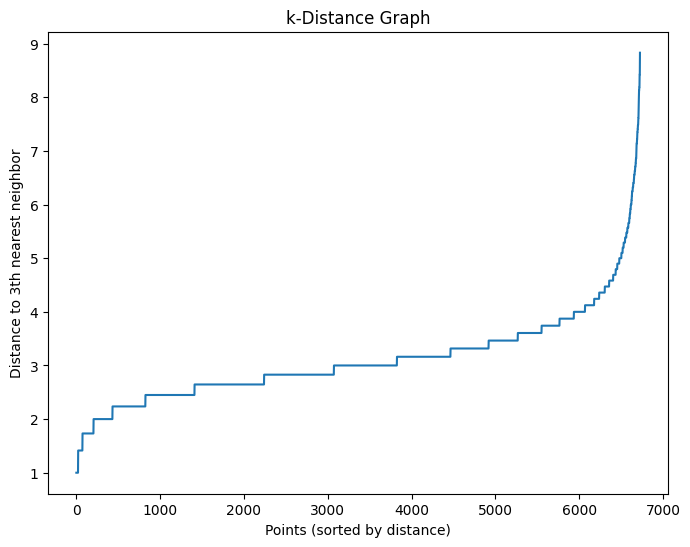

In [ ]:
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import numpy as np

# Assuming unique_vectors is a numpy array of shape (n_samples, 784)
# You can reduce dimensions first if needed (e.g., via PCA).

# Choose k equal to min_samples (e.g., 5).
k = 3
nbrs = NearestNeighbors(n_neighbors=k, algorithm='auto').fit(unique_vectors)
distances, indices = nbrs.kneighbors(unique_vectors)

# Sort distances to the k-th nearest neighbor for all points.
kth_distances = np.sort(distances[:, k-1])

plt.figure(figsize=(8, 6))
plt.plot(kth_distances)
plt.xlabel("Points (sorted by distance)")
plt.ylabel(f"Distance to {k}th nearest neighbor")
plt.title("k-Distance Graph")
plt.show()


In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from sklearn.cluster import DBSCAN
from sklearn.manifold import TSNE

# Set up DBSCAN parameters.
# eps is the maximum distance between two points to be considered neighbors.
# min_samples is the minimum number of neighbors to form a cluster.
eps = 4     # Adjust this based on your data scale.
min_samples = 3  # Adjust based on your desired cluster sensitivity.

# Apply DBSCAN clustering.
db = DBSCAN(eps=eps, min_samples=min_samples, metric='euclidean').fit(unique_vectors)
labels = db.labels_

# DBSCAN labels noise as -1.
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
print(f"DBSCAN found {n_clusters} clusters (excluding noise).")

# Total number of points.
total_points = unique_vectors.shape[0]

# Number of noise points (label == -1).
noise_count = np.sum(labels == -1)

# Points that belong to a cluster.
cluster_count = total_points - noise_count

# Percentage calculations.
noise_percent = (noise_count / total_points) * 100
cluster_percent = (cluster_count / total_points) * 100

print(f"Total points: {total_points}")
print(f"Cluster points: {cluster_count} ({cluster_percent:.2f}%)")
print(f"Noise points: {noise_count} ({noise_percent:.2f}%)")


DBSCAN found 9 clusters (excluding noise).
Total points: 6726
Cluster points: 6184 (91.94%)
Noise points: 542 (8.06%)


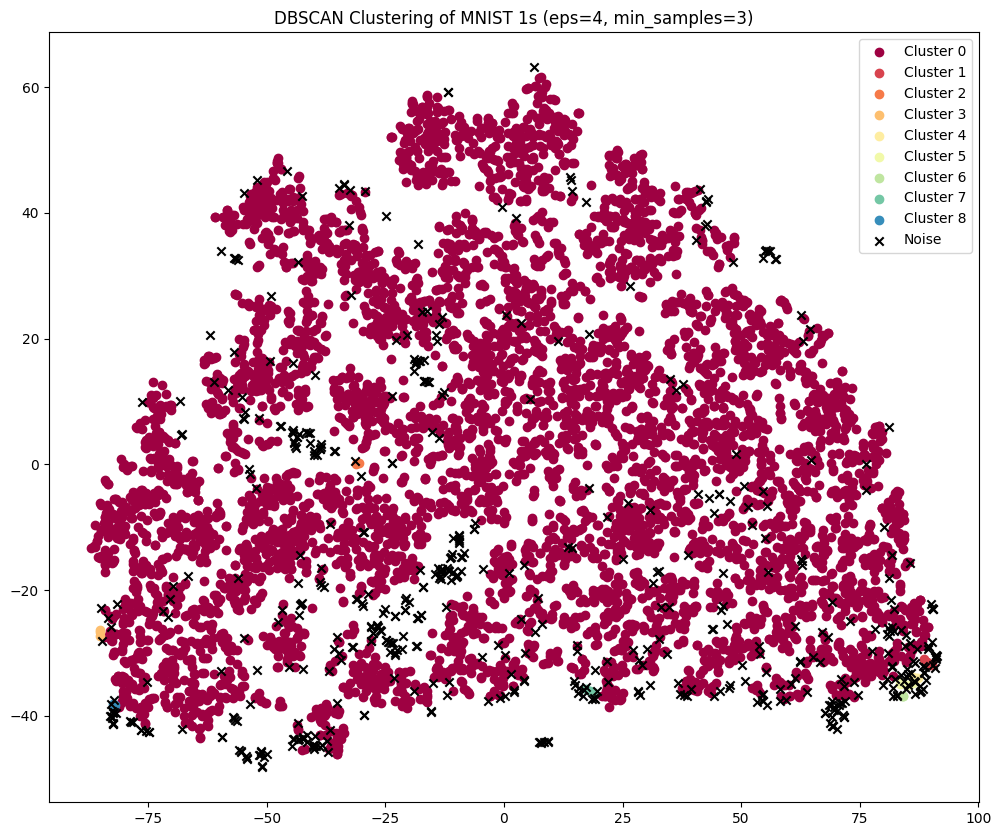

In [ ]:
# # Use t-SNE to reduce the 784D vectors to 2D for visualization.
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(unique_vectors)

# Plot the clusters.
plt.figure(figsize=(12, 10))
unique_labels = set(labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    # Create a mask for points in the current cluster.
    class_member_mask = (labels == k)
    xy = X_tsne[class_member_mask]

    if k == -1:
        # Noise points (if any) are plotted as black 'x'
        plt.scatter(xy[:, 0], xy[:, 1], c='k', marker='x', label='Noise')
    else:
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker='o', label=f'Cluster {k}')

plt.title(f"DBSCAN Clustering of MNIST 1s (eps={eps}, min_samples={min_samples})")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


HDBSCAN found 3 clusters
Noise points: 2679


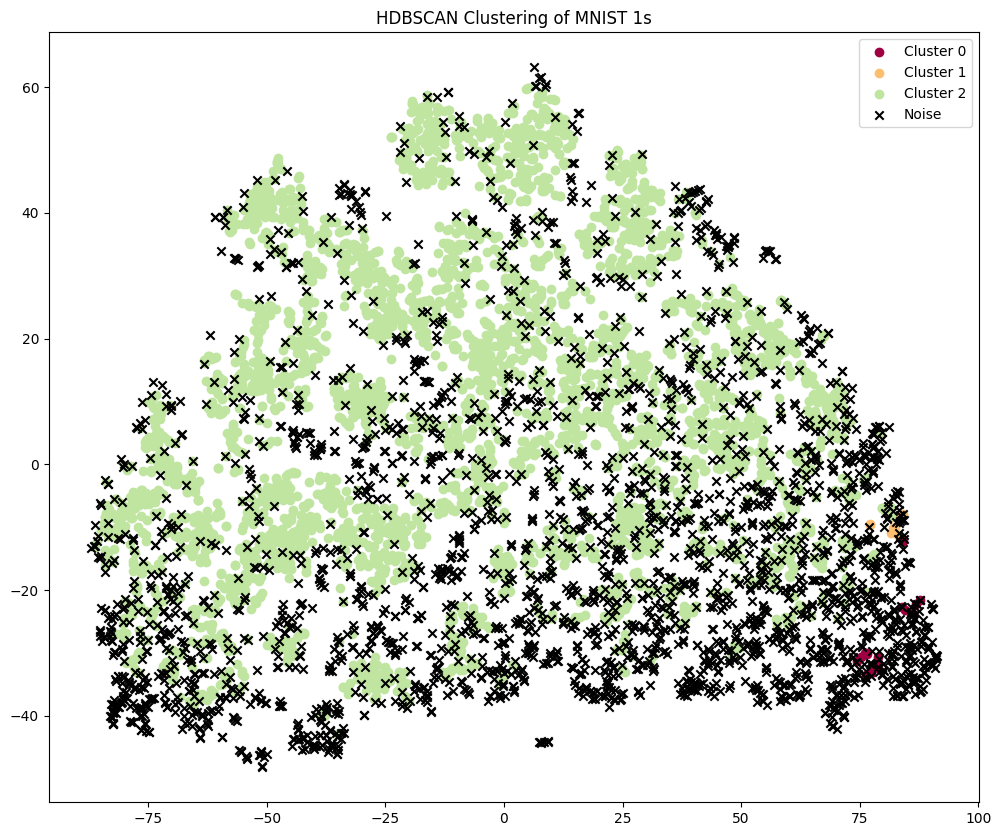

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import hdbscan
from sklearn.manifold import TSNE

# Ensure unique_vectors is a NumPy array.
if hasattr(unique_vectors, 'cpu'):
    data = unique_vectors.cpu().numpy()
else:
    data = unique_vectors

# Set up HDBSCAN parameters.
# min_cluster_size is the smallest size grouping that you wish to consider a cluster.
# min_samples can be set to control how conservative the clustering is (lower values produce fewer points marked as noise).
min_cluster_size = 10  # Adjust based on your expected cluster size.
min_samples = 3        # Adjust based on how strict you want the clustering to be.

# Create and fit the HDBSCAN clusterer.
clusterer = hdbscan.HDBSCAN(min_cluster_size=min_cluster_size, min_samples=min_samples, metric='euclidean')
cluster_labels = clusterer.fit_predict(data)

# Count the clusters and noise points.
n_clusters = len(set(cluster_labels)) - (1 if -1 in cluster_labels else 0)
n_noise = np.sum(cluster_labels == -1)
print(f"HDBSCAN found {n_clusters} clusters")
print(f"Noise points: {n_noise}")

# Optionally, use t-SNE to visualize the clusters in 2D.
X_tsne = TSNE(n_components=2, random_state=42).fit_transform(data)

plt.figure(figsize=(12, 10))
unique_labels = set(cluster_labels)
colors = plt.cm.Spectral(np.linspace(0, 1, len(unique_labels)))

for k, col in zip(unique_labels, colors):
    mask = (cluster_labels == k)
    xy = X_tsne[mask]
    if k == -1:
        plt.scatter(xy[:, 0], xy[:, 1], c='k', marker='x', label='Noise')
    else:
        plt.scatter(xy[:, 0], xy[:, 1], c=[col], marker='o', label=f'Cluster {k}')

plt.title("HDBSCAN Clustering of MNIST 1s")
plt.legend()
plt.show()


In [ ]:
# Compute cluster centroids (average vector for each DBSCAN cluster)
cluster_vectors = []  # This will hold the averaged vector for each cluster.
cluster_ids = []      # Optionally keep track of which cluster the centroid corresponds to.

# Iterate over each unique cluster label.
for k in set(labels):
    if k == -1:
        # Skip noise points.
        continue
    # Create a mask to select the vectors in cluster k.
    mask = (labels == k)

    # Compute the mean of all vectors in the cluster using PyTorch.
    centroid = torch.mean(unique_vectors[mask], dim=0)

    # Convert the centroid to a NumPy array and append.
    cluster_vectors.append(centroid.cpu().numpy())
    cluster_ids.append(k)

# Convert list to a numpy array.
cluster_vectors = np.array(cluster_vectors)
print("Computed centroids for", len(cluster_vectors), "clusters.")

Computed centroids for 95 clusters.


In [ ]:
import numpy as np
import networkx as nx
from sklearn.neighbors import NearestNeighbors

# Step 2: Build a kNN graph on the cluster centroids
k = 3  # Parameter: number of nearest neighbors to connect each centroid to.
nbrs = NearestNeighbors(n_neighbors=k + 1, algorithm='auto').fit(cluster_vectors)
distances, indices = nbrs.kneighbors(cluster_vectors)

G = nx.Graph()
n_clusters = cluster_vectors.shape[0]
G.add_nodes_from(range(n_clusters))

# Add edges based on the k nearest neighbors (skip the first neighbor, which is the node itself)
for i in range(n_clusters):
    for j in indices[i][1:]:
        # Optionally, use the Euclidean distance as the edge weight.
        weight = np.linalg.norm(cluster_vectors[i] - cluster_vectors[j])
        G.add_edge(i, j, weight=weight)

print("Constructed kNN graph with {} nodes and {} edges.".format(G.number_of_nodes(), G.number_of_edges()))


Constructed kNN graph with 95 nodes and 192 edges.


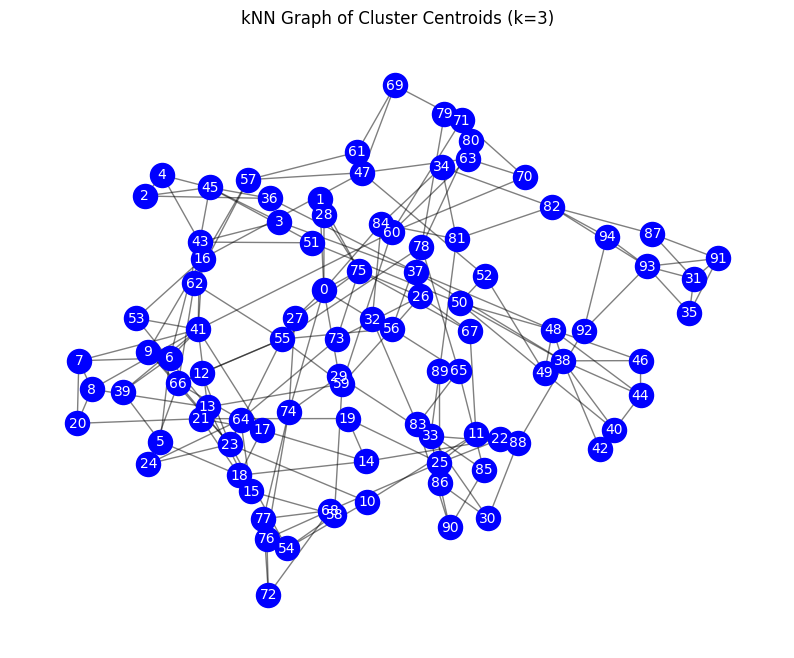

In [ ]:
# Use spring_layout to spread out the graph
pos = nx.spring_layout(G, k=0.5, seed=42)  # Increase 'k' for more spacing

plt.figure(figsize=(10, 8))
nx.draw_networkx_nodes(G, pos, node_color='blue', node_size=300)
nx.draw_networkx_edges(G, pos, alpha=0.5)
nx.draw_networkx_labels(G, pos, font_size=10, font_color='white')
plt.title(f"kNN Graph of Cluster Centroids (k={k})")
plt.axis('off')
plt.show()


In [ ]:
# Compute all pairs shortest path lengths using networkx
all_shortest_paths = dict(nx.all_pairs_shortest_path_length(G))

max_dist = 0
endpoints = (None, None)

# Iterate over each source and its corresponding target distances.
for source, distances in all_shortest_paths.items():
    for target, dist in distances.items():
        if dist > max_dist:
            max_dist = dist
            endpoints = (source, target)

print("The longest shortest path is between nodes:", endpoints, "with a distance of:", max_dist)


The longest shortest path is between nodes: (31, np.int64(42)) with a distance of: 16


In [ ]:
import numpy as np
import networkx as nx

# Assuming G is your kNN graph of cluster centroids
# and cluster_vectors is a numpy array of shape (n_clusters, 784)
# Also assume you've computed 'endpoints' as the two nodes with the longest shortest path.
# For example:
# endpoints = (node_a, node_b)

# Compute the shortest path between these two endpoints
path = nx.shortest_path(G, source=endpoints[0], target=endpoints[1])
print("Shortest path (cluster indices):", path)

# For each consecutive pair in the path, compute the transformation (delta vector)
transformations = []  # This will store the difference vectors.
print("\nTransformations between consecutive centroids:")
for i in range(len(path) - 1):
    start_vec = cluster_vectors[path[i]]
    end_vec = cluster_vectors[path[i+1]]
    delta = end_vec - start_vec
    transformations.append(delta)
    print(f"From cluster {path[i]} to {path[i+1]}: delta norm = {np.linalg.norm(delta):.4f}")

# Optionally, compute the overall transformation from the first to the last centroid:
overall_transformation = cluster_vectors[path[-1]] - cluster_vectors[path[0]]
print(f"\nOverall transformation from cluster {path[0]} to {path[-1]}: norm = {np.linalg.norm(overall_transformation):.4f}")


Shortest path (cluster indices): [31, np.int64(93), 82, 34, np.int64(84), 32, np.int64(83), 65, np.int64(78), np.int64(55), 62, np.int64(57), 47, 52, np.int64(49), 40, np.int64(42)]

Transformations between consecutive centroids:
From cluster 31 to 93: delta norm = 3.5119
From cluster 93 to 82: delta norm = 2.7080
From cluster 82 to 34: delta norm = 3.3686
From cluster 34 to 84: delta norm = 4.3221
From cluster 84 to 32: delta norm = 3.9158
From cluster 32 to 83: delta norm = 4.2426
From cluster 83 to 65: delta norm = 3.6353
From cluster 65 to 78: delta norm = 3.4094
From cluster 78 to 55: delta norm = 2.6336
From cluster 55 to 62: delta norm = 2.8981
From cluster 62 to 57: delta norm = 3.2798
From cluster 57 to 47: delta norm = 2.3334
From cluster 47 to 52: delta norm = 2.4625
From cluster 52 to 49: delta norm = 2.7801
From cluster 49 to 40: delta norm = 3.6209
From cluster 40 to 42: delta norm = 3.4641

Overall transformation from cluster 31 to 42: norm = 8.3832


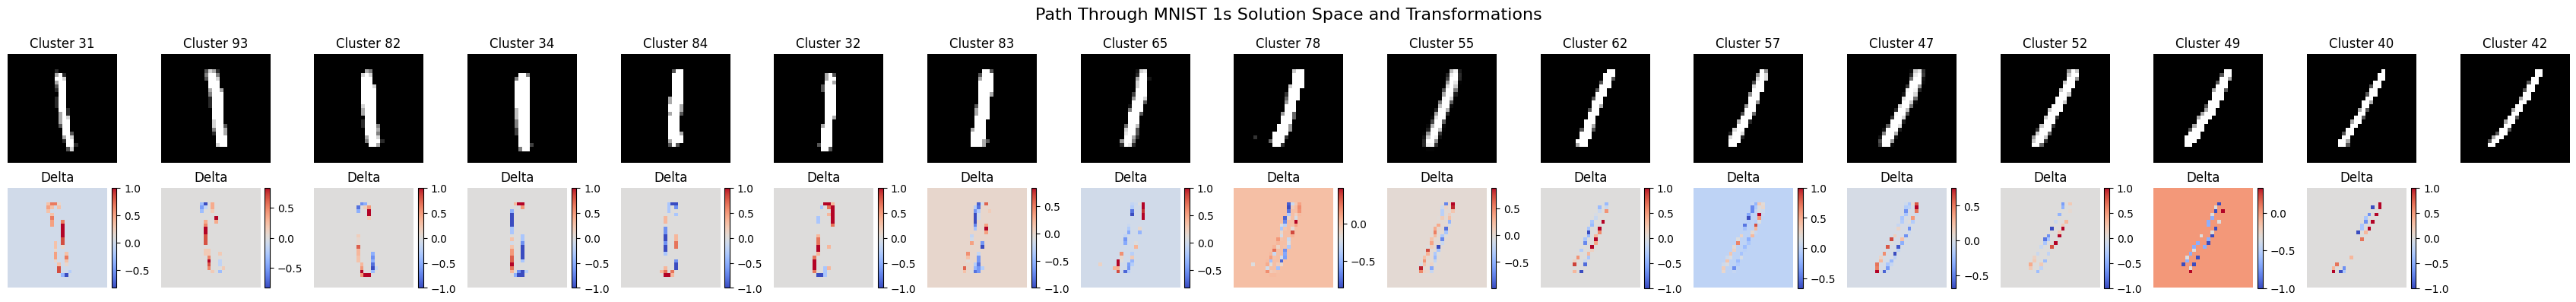

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def visualize_path_transformations(cluster_vectors, path):
    """
    Visualizes a sequence of cluster centroids and the transformation (difference)
    between each adjacent pair.

    Parameters:
    - cluster_vectors: numpy array of shape (n_clusters, 784). Each row is a centroid.
    - path: list of indices representing the path through clusters.
    """
    n = len(path)
    # Create a figure with two rows: top row for centroids, bottom row for differences.
    # We display the centroids in order and, below each pair, show the difference image.
    fig, axes = plt.subplots(2, n, figsize=(2 * n, 4))

    for i, idx in enumerate(path):
        # Reshape the centroid vector into a 28x28 image.
        img = cluster_vectors[idx].reshape(28, 28)
        axes[0, i].imshow(img, cmap='gray')
        axes[0, i].axis('off')
        axes[0, i].set_title(f"Cluster {idx}")

        # For all but the last centroid, compute and display the delta to the next centroid.
        if i < n - 1:
            delta = cluster_vectors[path[i+1]] - cluster_vectors[idx]
            # Show the delta as a heatmap. Using a diverging colormap emphasizes positive/negative changes.
            im = axes[1, i].imshow(delta.reshape(28, 28), cmap='coolwarm')
            axes[1, i].axis('off')
            axes[1, i].set_title("Delta")
            # Optionally add a colorbar to the delta plot
            plt.colorbar(im, ax=axes[1, i], fraction=0.046, pad=0.04)
        else:
            axes[1, i].axis('off')

    plt.suptitle("Path Through MNIST 1s Solution Space and Transformations", fontsize=16)
    plt.tight_layout()
    plt.show()

# Example usage:
# Assume `cluster_vectors` is your numpy array of shape (n_clusters, 784)
# and `path` is a list of cluster indices (e.g., from the longest shortest path).
# For example, if endpoints were found to be nodes 2 and 7:
# path = nx.shortest_path(G, source=2, target=7)
visualize_path_transformations(cluster_vectors, path)


Global cosine similarity (first vs. last): 0.1494


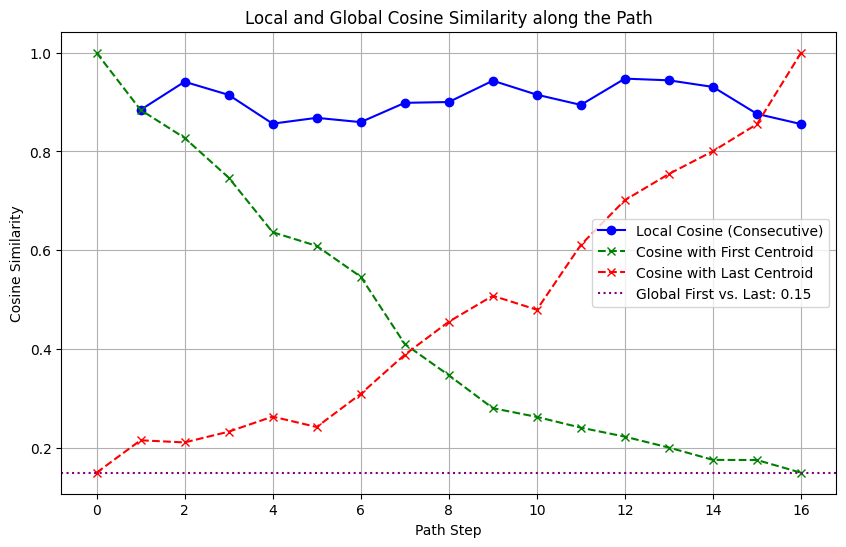

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def cosine_similarity(a, b):
    """Compute cosine similarity between two vectors."""
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

# Assume `path` is a list of cluster indices along your chosen path,
# and `cluster_vectors` is a numpy array of shape (n_clusters, 784)
# representing the centroids computed from DBSCAN clusters.
# Extract the centroids along the path:
path_centroids = np.array([cluster_vectors[idx] for idx in path])
num_steps = path_centroids.shape[0]

# Compute local cosine similarities: between consecutive centroids.
local_similarities = [
    cosine_similarity(path_centroids[i], path_centroids[i+1])
    for i in range(num_steps - 1)
]

# Compute global progression:
# Cosine similarity of each node with the first node.
global_first = [cosine_similarity(path_centroids[0], path_centroids[i])
                for i in range(num_steps)]
# Cosine similarity of each node with the last node.
global_last = [cosine_similarity(path_centroids[-1], path_centroids[i])
               for i in range(num_steps)]

# Compute the overall cosine similarity between first and last nodes.
global_similarity = cosine_similarity(path_centroids[0], path_centroids[-1])
print(f"Global cosine similarity (first vs. last): {global_similarity:.4f}")

# Plotting:
plt.figure(figsize=(10, 6))

# Plot the local cosine similarities.
# We'll plot these at positions 1, 2, ..., num_steps-1 (midpoints between consecutive centroids).
plt.plot(np.arange(1, num_steps), local_similarities, marker='o',
         linestyle='-', color='blue', label='Local Cosine (Consecutive)')

# Plot global similarity with the first centroid.
plt.plot(np.arange(num_steps), global_first, marker='x', linestyle='--',
         color='green', label='Cosine with First Centroid')

# Plot global similarity with the last centroid.
plt.plot(np.arange(num_steps), global_last, marker='x', linestyle='--',
         color='red', label='Cosine with Last Centroid')

# Optionally, add a horizontal line showing the overall first-to-last cosine similarity.
plt.axhline(y=global_similarity, color='purple', linestyle=':',
            label=f'Global First vs. Last: {global_similarity:.2f}')

plt.xlabel('Path Step')
plt.ylabel('Cosine Similarity')
plt.title('Local and Global Cosine Similarity along the Path')
plt.legend()
plt.grid(True)
plt.show()


Explained variance ratio: [0.37633353 0.14489244]


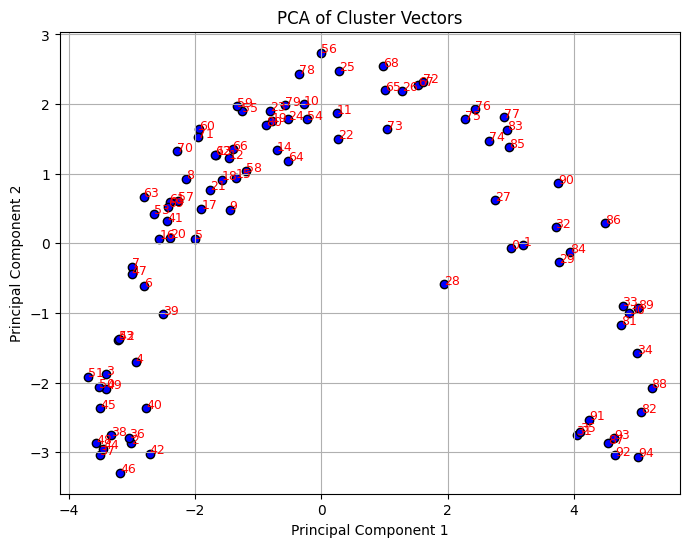

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# Assume cluster_vectors is a numpy array of shape (n_clusters, 784)
# where each row is the centroid for a DBSCAN cluster.

# Initialize PCA to reduce to 2 dimensions.
pca = PCA(n_components=2)
cluster_vectors_pca = pca.fit_transform(cluster_vectors)

# Print the explained variance ratio to see how much variance is captured.
print("Explained variance ratio:", pca.explained_variance_ratio_)

# Plot the PCA results.
plt.figure(figsize=(8, 6))
plt.scatter(cluster_vectors_pca[:, 0], cluster_vectors_pca[:, 1], c='blue', edgecolors='k')

# Optionally, annotate each point with its cluster index.
for i, (x, y) in enumerate(cluster_vectors_pca):
    plt.text(x, y, str(cluster_ids[i]), fontsize=9, color='red')

plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("PCA of Cluster Vectors")
plt.grid(True)
plt.show()


In [ ]:
import numpy as np
import kmapper as km
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import DBSCAN
from ripser import ripser
import persim

# Use PCA as a lens to project the data to 2D.
pca = PCA(n_components=2)
lens = pca.fit_transform(unique_vectors)

# Create a KeplerMapper object.
mapper = km.KeplerMapper(verbose=1)

# Define the cover parameters.
cover = km.Cover(n_cubes=15, perc_overlap=0.3)

# Cluster using DBSCAN. You may need to adjust eps and min_samples based on your data.
clusterer = DBSCAN(eps=6, min_samples=5)

# Build the mapper graph.
graph = mapper.map(lens,
                   unique_vectors,
                   cover=cover,
                   clusterer=clusterer)

# Visualize the mapper graph.
# This will create an interactive HTML file you can open in a browser.
mapper.visualize(graph,
                 path_html="mapper_mnist1.html",
                 title="Mapper Graph of MNIST 1s")
print("Mapper visualization saved as 'mapper_mnist1.html'.")

KeplerMapper(verbose=1)
Mapping on data shaped torch.Size([6726, 784]) using lens shaped (6726, 2)

Creating 225 hypercubes.

Created 499 edges and 153 nodes in 0:00:01.028934.
Wrote visualization to: mapper_mnist1.html
Mapper visualization saved as 'mapper_mnist1.html'.


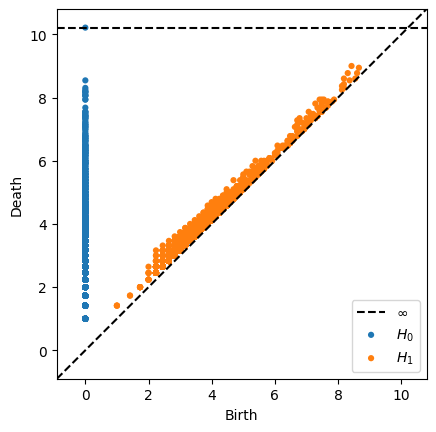

In [ ]:
# Compute persistent homology on your data.
# maxdim=1 computes connected components (H0) and loops (H1).
ph_result = ripser(unique_vectors, maxdim=1)

# Plot persistence diagrams.
persim.plot_diagrams(ph_result['dgms'], show=True)

1 connected component at the end, no long lived loops.